### In this notebook, we generate results for multiple thresholds on containment fraction.

In [17]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import classification_report
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
training = pd.read_csv('training-simplified-data-generation.csv')
test = pd.read_csv('test-simplified-data-generation.csv')

#### Let's (sanity-)check how many candidates per query there are in these datasets.

In [4]:
training_queries = set(training['query'])
test_queries = set(test['query'])

In [5]:
len(training_queries) == training.shape[0]

True

In [6]:
len(test_queries) == test.shape[0]

True

#### Ok. So there's no overlap in query features in both the training and the test set, which is good for our current analyses.

In [7]:
training_queries & test_queries

set()

#### Alright. So if there's no overlap, we can generate different versions of these datasets based on distinct containment ratio thresholds $\theta$.

In [8]:
THRESHOLDS = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5,
              0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.0]
def generate_different_dataset_versions(dataset):
    pruned_datasets = []
    for thresh in THRESHOLDS:
        pruned_datasets.append(dataset.loc[dataset['containment_fraction'] >= thresh])
    return pruned_datasets

In [9]:
training_datasets_different_theta = generate_different_dataset_versions(training)

In [10]:
test_datasets_different_theta = generate_different_dataset_versions(test)

#### Now, let's train and test taking the thresholds into account.

In [11]:
FEATURES = ['query_num_of_columns', 'query_num_of_rows', 'query_row_column_ratio',
                'query_max_skewness', 'query_max_kurtosis', 'query_max_unique', 
                'candidate_num_rows', 'candidate_max_skewness', 'candidate_max_kurtosis',
                'candidate_max_unique', 'query_target_max_pearson', 
                'query_target_max_spearman', 'query_target_max_covariance', 
                'query_target_max_mutual_info', 'candidate_target_max_pearson', 
                'candidate_target_max_spearman', 'candidate_target_max_covariance', 
                'candidate_target_max_mutual_info']

In [12]:
from sklearn.preprocessing import StandardScaler

NORMALIZABLE_FEATURES = ['query_num_of_columns', 'query_num_of_rows', 'query_row_column_ratio',
                'query_max_skewness', 'query_max_kurtosis', 'query_max_unique', 
                'candidate_num_rows', 'candidate_max_skewness', 'candidate_max_kurtosis',
                'candidate_max_unique', 'query_target_max_covariance', 
                'query_target_max_mutual_info', 'candidate_target_max_covariance', 
                'candidate_target_max_mutual_info']

def normalize_dataset(dataset):
    standard_scaler = StandardScaler()
    for feature in NORMALIZABLE_FEATURES:
        dataset[feature] = standard_scaler.fit_transform(np.array(dataset[feature]).reshape(-1, 1))
    return dataset

#### I'm adding a simple normalization method here but I'm not sure about how we should use it to normalize test data. Should we normalize candidate features considering only candidates for a same query? And how should we normalize the query features (I know there's only one candidate per query here, but there are cases where there are many)? In a practical scenario, we only get one query at a time, so we won't have much of a "reference" against which we can normalize query features.

In [13]:
def calculate_performance_for_different_training_and_test_pairs(training_datasets, test_datasets):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    for training, test in zip(training_datasets, test_datasets):
        normed_training = normalize_dataset(training)
        normed_training['class'] = ['gain' if row['gain_in_r2_score'] > 0 else 'loss' for index, row in normed_training.iterrows()]
        normed_test = normalize_dataset(test)
        normed_test['class'] = ['gain' if row['gain_in_r2_score'] > 0 else 'loss' for index, row in normed_test.iterrows()]
        rf.fit(normed_training[FEATURES], normed_training['class'])
        preds = rf.predict(normed_test[FEATURES])
        print(classification_report(normed_test['class'], preds))

In [18]:
calculate_performance_for_different_training_and_test_pairs(training_datasets_different_theta, test_datasets_different_theta)

              precision    recall  f1-score   support

        gain       0.65      0.78      0.71      1960
        loss       0.52      0.37      0.43      1305

    accuracy                           0.61      3265
   macro avg       0.59      0.57      0.57      3265
weighted avg       0.60      0.61      0.60      3265

              precision    recall  f1-score   support

        gain       0.65      0.78      0.71      1962
        loss       0.52      0.35      0.42      1310

    accuracy                           0.61      3272
   macro avg       0.58      0.57      0.56      3272
weighted avg       0.60      0.61      0.59      3272

              precision    recall  f1-score   support

        gain       0.65      0.78      0.71      1967
        loss       0.53      0.37      0.44      1314

    accuracy                           0.62      3281
   macro avg       0.59      0.58      0.57      3281
weighted avg       0.60      0.62      0.60      3281

              preci

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def plot_fmeasures_and_supports(fmeasures, supports, title):
  fig, ax1 = plt.subplots()
  color = '#1d3557'
  ax1.set_xlabel(r'Threshold $\theta$')
  ax1.xaxis.label.set_size(16)
  #ax1.set_xlim(xmin=0.248,xmax=0.652)
  #extraticks = [0.25, 0.35, 0.45, 0.55, 0.65]
  #ax1.set_xticks(extraticks) #list(ax1.get_xticks()) +
  ax1.set_ylabel(r'Support', color=color) # ($\ln$)
  ax1.yaxis.label.set_size(16)
  ax1.plot(THRESHOLDS, supports, 'o--', dashes=(5,10), color=color, linewidth=3, label='support')
  ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
  ax1.tick_params(axis='x',  labelsize=12)

  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
  #ax2.set_xlim(xmin=0.248,xmax=0.652)
  ax2.xaxis.label.set_size(16)
  #ax2.set_xticks(list(ax2.get_xticks()) + extraticks)
  color = '#e63946'
  ax2.set_ylabel(r'F-measure', color=color)  # we already handled the x-label with ax1
  ax2.yaxis.label.set_size(16)
  #ax2.set_ylim(ymin=0.475,ymax=0.585)
  ax2.plot(THRESHOLDS, fmeasures, 'o-', color=color, linewidth=3, label='f-measure')
  ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
  ax2.tick_params(axis='x',  labelsize=12)
  plt.title(title)
  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  plt.savefig('varying-containment.png', dpi=600)
  plt.show()


#### Note that the f-score increases as the containment ratio threshold increases as well... Let's plot support and f-measure.

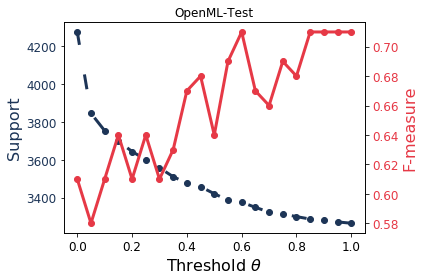

In [20]:
fmeasures = [0.71, 0.71, 0.71, 0.71, 0.68, 0.69, 0.66, 0.67, 0.71, 
             0.69, 0.64, 0.68, 0.67, 0.63, 0.61, 0.64, 0.61, 0.64, 0.61, 0.58, 0.61]
positive_supports = [1960, 1962, 1967, 1972, 1977, 1983, 1991, 2007, 2026, 2030, 2050, 2072, 
            2082, 2101, 2126, 2145, 2161, 2197, 2227, 2267, 2496]
supports = [3265, 3272, 3281, 3287, 3300, 3314, 3324, 3349, 3376, 3387, 3421, 3458,
            3477, 3511, 3558, 3601, 3644, 3699, 3754, 3846, 4276]
plot_fmeasures_and_supports(fmeasures, supports, 'OpenML-Test')

#### Note that there is an ascending trend in the F-Measure, but it is hard to know where to "cut" here: 0.3? 0.4? 0.5? For now, we'll use $\theta$ == 0.6 for all experiments.

In [21]:
# datasets 

pruned_training = training_datasets_different_theta[8]
pruned_test = test_datasets_different_theta[8]


In [22]:
pruned_training.shape

(7932, 36)

In [23]:
pruned_test.shape

(3376, 36)

In [24]:
pruned_training.loc[pruned_training['class'] == 'gain'].shape


(4774, 36)

In [25]:
pruned_test.loc[pruned_test['class'] == 'gain'].shape

(2026, 36)

#### Let's compare the results we obtained with $\theta$ = 0.6 against other methodologies (one with added noise and one with many candidates per query, both also using threshold $\theta$ = 0.6.

#### It was taking too long to get results for the "many-candidates" methodology on this notebook, so I generated the results on ipython on my terminal and attached them below as text.

In [26]:
THETA = 0.6

training_official = pruned_training

training_noise = pd.read_csv('training-with-noise-data-generation.csv')
training_noise = training_noise.loc[training_noise['containment_fraction'] >= THETA]
training_noise = normalize_dataset(training_noise)
training_noise['class'] = ['gain' if row['gain_in_r2_score'] > 0 else 'loss' for index, row in training_noise.iterrows()]

test = pruned_test

In [27]:
rf_official = RandomForestClassifier(n_estimators=100, random_state=42)
rf_official.fit(training_official[FEATURES], training_official['class'])
preds = rf_official.predict(test[FEATURES])
print(classification_report(test['class'], preds))

              precision    recall  f1-score   support

        gain       0.65      0.77      0.71      2026
        loss       0.53      0.39      0.45      1350

    accuracy                           0.62      3376
   macro avg       0.59      0.58      0.58      3376
weighted avg       0.60      0.62      0.60      3376



In [28]:
rf_noise = RandomForestClassifier(n_estimators=100, random_state=42)
rf_noise.fit(training_noise[FEATURES], training_noise['class'])
preds = rf_noise.predict(test[FEATURES])
print(classification_report(test['class'], preds))

              precision    recall  f1-score   support

        gain       0.67      0.58      0.62      2026
        loss       0.48      0.58      0.52      1350

    accuracy                           0.58      3376
   macro avg       0.58      0.58      0.57      3376
weighted avg       0.59      0.58      0.58      3376



#### Results for "many candidates" methodology:

                precision    recall  f1-score   support

        gain       0.69      0.59      0.63      2026
        loss       0.49      0.60      0.54      1350

    accuracy                           0.59      3376


#### Let's check the percentage of successful and unsuccessful augmentations for all these different datasets

In [29]:
print('training_official -- number of rows', training_official.shape[0], 
      'positive augs', float(training_official.loc[training_official['class'] == 'gain'].shape[0])/training_official.shape[0],
      'negative augs', float(training_official.loc[training_official['class'] == 'loss'].shape[0])/training_official.shape[0])

training_official -- number of rows 7932 positive augs 0.6018658598083712 negative augs 0.39813414019162885


In [30]:
print('test -- number of rows', test.shape[0], 
      'positive augs', float(test.loc[test['class'] == 'gain'].shape[0])/test.shape[0],
      'negative augs', float(test.loc[test['class'] == 'loss'].shape[0])/test.shape[0])

test -- number of rows 3376 positive augs 0.6001184834123223 negative augs 0.39988151658767773


In [31]:
print('training_noise -- number of rows', training_noise.shape[0], 
      'positive augs', float(training_noise.loc[training_noise['class'] == 'gain'].shape[0])/training_noise.shape[0],
      'negative augs', float(training_noise.loc[training_noise['class'] == 'loss'].shape[0])/training_noise.shape[0])

training_noise -- number of rows 5013 positive augs 0.5344105326152004 negative augs 0.4655894673847995


#### For the "many candidates" methodology, we have 1266624 rows, 48% positive and 52% negative. 

#### Let's see which features are most important for rf_official

In [32]:
print(sorted([(i, j) for i, j in zip(FEATURES, rf_official.feature_importances_)],
            key=lambda x: x[1], reverse=True))

[('candidate_target_max_pearson', 0.09849076660016301), ('candidate_target_max_spearman', 0.0938912234672648), ('query_row_column_ratio', 0.08464838829542287), ('candidate_max_kurtosis', 0.07204317764663211), ('candidate_max_skewness', 0.07195784973431611), ('query_target_max_pearson', 0.0651465659091578), ('query_num_of_columns', 0.06386297563720769), ('query_target_max_spearman', 0.06381621444399013), ('query_max_kurtosis', 0.06212454990794925), ('query_max_skewness', 0.05720125836070155), ('candidate_target_max_mutual_info', 0.04862111068774083), ('candidate_max_unique', 0.042091229099697536), ('candidate_num_rows', 0.03757524954044709), ('query_target_max_mutual_info', 0.036941819371807606), ('query_max_unique', 0.03689081270259695), ('query_num_of_rows', 0.024573660137982397), ('query_target_max_covariance', 0.021799436516301448), ('candidate_target_max_covariance', 0.018323711940620838)]


#### Let's compare rf_official with a few baselines now. Let's start with a hierarchical one.

In [33]:
DATASET_QUERY_FEATURES = ['query_target_max_pearson', 
                'query_target_max_spearman', 'query_target_max_covariance', 
                'query_target_max_mutual_info', 'candidate_target_max_pearson', 
                'candidate_target_max_spearman', 'candidate_target_max_covariance', 
                'candidate_target_max_mutual_info']

DATASET_FEATURES = ['query_num_of_columns', 'query_num_of_rows', 'query_row_column_ratio',
                'query_max_skewness', 'query_max_kurtosis', 'query_max_unique', 
                'candidate_num_rows', 'candidate_max_skewness', 'candidate_max_kurtosis',
                'candidate_max_unique']


rf_dataset_query_features = RandomForestClassifier(n_estimators=100, random_state=42)
rf_dataset_query_features.fit(training_official[DATASET_QUERY_FEATURES], training_official['class'])
preds_dataset_query_features = rf_dataset_query_features.predict(test[DATASET_QUERY_FEATURES])

rf_dataset_features = RandomForestClassifier(n_estimators=100, random_state=42)
rf_dataset_features.fit(training_official[DATASET_FEATURES], training_official['class'])
preds_dataset_features = rf_dataset_features.predict(test[DATASET_FEATURES])

preds = ['gain' if i == 'gain' and j == 'gain' else 'loss' for i, j in zip(preds_dataset_query_features, preds_dataset_features)]
print(classification_report(test['class'], preds))

              precision    recall  f1-score   support

        gain       0.65      0.47      0.54      2026
        loss       0.44      0.62      0.51      1350

    accuracy                           0.53      3376
   macro avg       0.54      0.54      0.53      3376
weighted avg       0.56      0.53      0.53      3376



In [34]:
from scipy.spatial.distance import euclidean
import random

positive_centroid = training_official.loc[training_official['class'] == 'gain'][FEATURES].mean()
negative_centroid = training_official.loc[training_official['class'] == 'loss'][FEATURES].mean()

preds = []
for index, row in test.iterrows():
    dist_pos = euclidean(positive_centroid, row[FEATURES])
    dist_neg = euclidean(negative_centroid, row[FEATURES])
    if dist_pos < dist_neg:
        preds.append('gain')
    else: 
        preds.append('loss')
print(classification_report(test['class'], preds))

              precision    recall  f1-score   support

        gain       0.66      0.63      0.65      2026
        loss       0.48      0.52      0.50      1350

    accuracy                           0.59      3376
   macro avg       0.57      0.58      0.57      3376
weighted avg       0.59      0.59      0.59      3376



#### Now let's check the probability distribution of predictions for test with rf_official

In [35]:
preds_proba = [i[0] for i in rf_official.predict_proba(test[FEATURES])]
print(preds_proba)

[0.54, 0.53, 0.54, 0.57, 0.49, 0.56, 0.52, 0.57, 0.7, 0.51, 0.44, 0.61, 0.66, 0.41, 0.53, 0.695, 0.49, 0.5916666666666667, 0.84, 0.77, 0.53, 0.63, 0.58, 0.44, 0.43, 0.46, 0.47, 0.57, 0.49333333333333335, 0.5533333333333332, 0.54, 0.45, 0.79, 0.46, 0.59, 0.69, 0.445, 0.49, 0.42, 0.68, 0.48, 0.5533333333333332, 0.58, 0.49, 0.47, 0.48, 0.78, 0.48, 0.53, 0.7125, 0.63, 0.44, 0.49, 0.81, 0.48, 0.51, 0.44, 0.44, 0.47, 0.42, 0.47, 0.55, 0.55, 0.47, 0.44, 0.43, 0.39, 0.56, 0.59, 0.43, 0.46, 0.4666666666666666, 0.55, 0.43, 0.51, 0.52, 0.59, 0.5, 0.5, 0.48, 0.6725, 0.42, 0.69, 0.62, 0.595, 0.41, 0.68, 0.54, 0.56, 0.62, 0.6, 0.53, 0.53, 0.5, 0.6, 0.59, 0.59, 0.48, 0.685, 0.82, 0.5366666666666667, 0.54, 0.45, 0.54, 0.9, 0.6, 0.53, 0.475, 0.5, 0.51, 0.5, 0.71, 0.4, 0.52, 0.58, 0.58, 0.52, 0.67, 0.53, 0.53, 0.415, 0.51, 0.77, 0.5, 0.86, 0.53, 0.63, 0.62, 0.72, 0.57, 0.7, 0.44, 0.48, 0.58, 0.47, 0.72, 0.71, 0.77, 0.58, 0.38, 0.52, 0.32, 0.49, 0.4, 0.65, 0.61, 0.57, 0.49, 0.49, 0.6633333333333334, 0.5,

In [36]:
probs_hist = [len([i for i in preds_proba if i < 0.05]),
              len([i for i in preds_proba if i >= 0.05 and i < 0.1]),
              len([i for i in preds_proba if i >= 0.1 and i < 0.15]),
              len([i for i in preds_proba if i >= 0.15 and i < 0.2]),
              len([i for i in preds_proba if i >= 0.2 and i < 0.25]),
              len([i for i in preds_proba if i >= 0.25 and i < 0.3]),
              len([i for i in preds_proba if i >= 0.3 and i < 0.35]),
              len([i for i in preds_proba if i >= 0.35 and i < 0.4]),
              len([i for i in preds_proba if i >= 0.4 and i < 0.45]),
              len([i for i in preds_proba if i >= 0.45 and i < 0.5]),
              len([i for i in preds_proba if i >= 0.5 and i < 0.55]),
              len([i for i in preds_proba if i >= 0.55 and i < 0.6]),
              len([i for i in preds_proba if i >= 0.6 and i < 0.65]),
              len([i for i in preds_proba if i >= 0.65 and i < 0.7]),
              len([i for i in preds_proba if i >= 0.7 and i < 0.75]),
              len([i for i in preds_proba if i >= 0.75 and i < 0.8]),
              len([i for i in preds_proba if i >= 0.8 and i < 0.85]),
              len([i for i in preds_proba if i >= 0.85 and i < 0.9]),
              len([i for i in preds_proba if i >= 0.9 and i < 0.95]),
              len([i for i in preds_proba if i >= 0.95 and i <= 1])]
print([i for i in probs_hist])

[0, 0, 0, 0, 0, 2, 11, 77, 305, 597, 797, 617, 340, 242, 181, 107, 47, 28, 21, 4]


In [37]:
(597+797)/float(sum(probs_hist))

0.41291469194312796

In [38]:
test['official_preds'] = preds
test['official_preds_proba'] = preds_proba
certain_test = test.loc[(test['official_preds_proba'] < 0.45) | (test['official_preds_proba'] > 0.55)]
print(classification_report(certain_test['class'], certain_test['official_preds']))

              precision    recall  f1-score   support

        gain       0.75      0.72      0.73      1242
        loss       0.47      0.50      0.48       609

    accuracy                           0.65      1851
   macro avg       0.61      0.61      0.61      1851
weighted avg       0.65      0.65      0.65      1851



In [39]:
fp = test.loc[(test['class'] == 'loss') | (test['official_preds'] == 'gain')].shape[0]
fn = test.loc[(test['class'] == 'gain') | (test['official_preds'] == 'loss')].shape[0]

certain_fp = certain_test.loc[(certain_test['class'] == 'loss') | (certain_test['official_preds'] == 'gain')].shape[0]
certain_fn = certain_test.loc[(certain_test['class'] == 'gain') | (certain_test['official_preds'] == 'loss')].shape[0]
print(certain_fp/float(fp), certain_fn/float(fn))

0.5742083174360931 0.5655197657393851


#### Now, let's see how rf_official works for three different use cases: Taxi-Demand, College-Test, and Poverty-Estimation

In [112]:
THETA = 0.6
taxi_demand = pd.read_csv('taxi-vehicle-collision-records-features-single-column-w-class')
taxi_demand = taxi_demand.loc[taxi_demand['containment_fraction'] >= THETA]
taxi_demand = normalize_dataset(taxi_demand)
taxi_demand['class'] = ['gain' if row['gain_in_r2_score'] > 0 else 'loss' for index, row in taxi_demand.iterrows()]

college_test = pd.read_csv('college-debt-records-features-single-column-w-class')
college_test = college_test.loc[college_test['containment_fraction'] >= THETA]
college_test = normalize_dataset(college_test)
college_test['class'] = ['gain' if row['gain_in_r2_score'] > 0 else 'loss' for index, row in college_test.iterrows()]

poverty_estimation = pd.read_csv('poverty-estimation-results-features-and-targets-training.csv')
poverty_estimation = poverty_estimation.loc[poverty_estimation['containment_fraction'] >= THETA]
poverty_estimation = normalize_dataset(poverty_estimation)
poverty_estimation['class'] = ['gain' if row['gain_in_r2_score'] > 0 else 'loss' for index, row in poverty_estimation.iterrows()]


#### Let's see how many candidates, successful, and unsuccessful augmentations there are for each case study.

In [113]:
print(taxi_demand.shape[0], 
      taxi_demand.loc[taxi_demand['class'] == 'gain'].shape[0]/float(taxi_demand.shape[0]),
      taxi_demand.loc[taxi_demand['class'] == 'loss'].shape[0]/float(taxi_demand.shape[0]))

print(college_test.shape[0], 
      college_test.loc[college_test['class'] == 'gain'].shape[0]/float(college_test.shape[0]),
      college_test.loc[college_test['class'] == 'loss'].shape[0]/float(college_test.shape[0]))

print(poverty_estimation.shape[0], 
      poverty_estimation.loc[poverty_estimation['class'] == 'gain'].shape[0]/float(poverty_estimation.shape[0]),
      poverty_estimation.loc[poverty_estimation['class'] == 'loss'].shape[0]/float(poverty_estimation.shape[0]))


18 1.0 0.0
111 0.7747747747747747 0.22522522522522523
11 1.0 0.0


In [114]:
preds = rf_official.predict(taxi_demand[FEATURES])
print(classification_report(taxi_demand['class'], preds))

              precision    recall  f1-score   support

        gain       1.00      0.78      0.88        18
        loss       0.00      0.00      0.00         0

    accuracy                           0.78        18
   macro avg       0.50      0.39      0.44        18
weighted avg       1.00      0.78      0.88        18



In [115]:
preds = rf_official.predict(college_test[FEATURES])
print(classification_report(college_test['class'], preds))

              precision    recall  f1-score   support

        gain       1.00      0.67      0.81        86
        loss       0.47      1.00      0.64        25

    accuracy                           0.75       111
   macro avg       0.74      0.84      0.72       111
weighted avg       0.88      0.75      0.77       111



In [116]:
preds = rf_official.predict(poverty_estimation[FEATURES])
print(classification_report(poverty_estimation['class'], preds))

              precision    recall  f1-score   support

        gain       1.00      0.82      0.90        11
        loss       0.00      0.00      0.00         0

    accuracy                           0.82        11
   macro avg       0.50      0.41      0.45        11
weighted avg       1.00      0.82      0.90        11



#### Let's use eli5 to understand why we got lower recall for the case studies.

In [119]:
import eli5

#low recall means false negatives.
preds = rf_official.predict(taxi_demand[FEATURES])
taxi_demand['pred'] = preds
false_negative = taxi_demand.loc[(taxi_demand['class'] == 'gain') & (taxi_demand['pred'] == 'loss')]
false_negative.shape

(4, 40)

In [121]:
no_bias = lambda feature_name, feature_value: feature_name != '<BIAS>'
eli5.show_prediction(rf_official, false_negative.iloc[0][FEATURES], 
                     show_feature_values=True, feature_filter=no_bias)

In [122]:
eli5.show_prediction(rf_official, false_negative.iloc[1][FEATURES], 
                     show_feature_values=True, feature_filter=no_bias)

In [123]:
eli5.show_prediction(rf_official, false_negative.iloc[2][FEATURES], 
                     show_feature_values=True, feature_filter=no_bias)

In [124]:
eli5.show_prediction(rf_official, false_negative.iloc[3][FEATURES], 
                     show_feature_values=True, feature_filter=no_bias)

In [126]:
preds = rf_official.predict(college_test[FEATURES])
college_test['pred'] = preds
false_negative = college_test.loc[(college_test['class'] == 'gain') & (college_test['pred'] == 'loss')]
sample_false_negative = false_negative.sample(5)

In [127]:
eli5.show_prediction(rf_official, sample_false_negative.iloc[0][FEATURES], 
                     show_feature_values=True, feature_filter=no_bias)

In [128]:
eli5.show_prediction(rf_official, sample_false_negative.iloc[1][FEATURES], 
                     show_feature_values=True, feature_filter=no_bias)

In [129]:
eli5.show_prediction(rf_official, sample_false_negative.iloc[2][FEATURES], 
                     show_feature_values=True, feature_filter=no_bias)

In [130]:
eli5.show_prediction(rf_official, sample_false_negative.iloc[3][FEATURES], 
                     show_feature_values=True, feature_filter=no_bias)

In [131]:
eli5.show_prediction(rf_official, sample_false_negative.iloc[4][FEATURES], 
                     show_feature_values=True, feature_filter=no_bias)

In [132]:
preds = rf_official.predict(poverty_estimation[FEATURES])
poverty_estimation['pred'] = preds
false_negative = poverty_estimation.loc[(poverty_estimation['class'] == 'gain') & (poverty_estimation['pred'] == 'loss')]
#sample_false_negative = false_negative.sample(5)
false_negative.shape

(2, 38)

#### Let's check how many candidates there are for each case study keeping THETA = 0

In [133]:
THETA = 0.0
taxi_demand = pd.read_csv('taxi-vehicle-collision-records-features-single-column-w-class')
taxi_demand = taxi_demand.loc[taxi_demand['containment_fraction'] >= THETA]
taxi_demand = normalize_dataset(taxi_demand)
taxi_demand['class'] = ['gain' if row['gain_in_r2_score'] > 0 else 'loss' for index, row in taxi_demand.iterrows()]

college_test = pd.read_csv('college-debt-records-features-single-column-w-class')
college_test = college_test.loc[college_test['containment_fraction'] >= THETA]
college_test = normalize_dataset(college_test)
college_test['class'] = ['gain' if row['gain_in_r2_score'] > 0 else 'loss' for index, row in college_test.iterrows()]

poverty_estimation = pd.read_csv('poverty-estimation-results-features-and-targets-training.csv')
poverty_estimation = poverty_estimation.loc[poverty_estimation['containment_fraction'] >= THETA]
poverty_estimation = normalize_dataset(poverty_estimation)
poverty_estimation['class'] = ['gain' if row['gain_in_r2_score'] > 0 else 'loss' for index, row in poverty_estimation.iterrows()]

print(taxi_demand.shape, college_test.shape, poverty_estimation.shape)

(447, 39) (1103, 39) (130928, 37)


In [135]:
print(taxi_demand.loc[taxi_demand['class'] == 'gain'].shape, 
      college_test.loc[college_test['class'] == 'gain'].shape,
      poverty_estimation.loc[poverty_estimation['class'] == 'gain'].shape)

(447, 39) (130, 39) (11526, 37)


#### The values remained pretty much the same. Let's see how the number candidates varies for different $\theta$ values, and how IDA performs.

In [139]:
def calculate_performance_for_different_containment_ratios(training, test_datasets):
    thresholds = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    for thresh in thresholds:
        tmp_training = training.loc[training['containment_fraction'] >= thresh]
        tmp_training = normalize_dataset(tmp_training)
        rf.fit(tmp_training[FEATURES], tmp_training['class'])
        for test_name in test_datasets.keys():
            tmp_test = test_datasets[test_name].loc[test_datasets[test_name]['containment_fraction'] >= thresh]
            tmp_test = normalize_dataset(tmp_test)
            preds = rf.predict(tmp_test[FEATURES])
            print('****', test_name, 'containment_fraction >=', thresh)
            print(classification_report(tmp_test['class'], preds))

In [ ]:
training = pd.read_csv('training-simplified-data-generation.csv')
training['class'] = ['gain' if row['gain_in_r2_score'] > 0 else 'loss' for index, row in training.iterrows()]

college = pd.read_csv('college-debt-records-features-single-column-w-class')
college['class'] = ['gain' if row['gain_in_r2_score'] > 0 else 'loss' for index, row in college.iterrows()]

poverty = pd.read_csv('poverty-estimation-results-features-and-targets-training.csv')
poverty['class'] = ['gain' if row['gain_in_r2_score'] > 0 else 'loss' for index, row in poverty.iterrows()]

taxi = pd.read_csv('taxi-vehicle-collision-records-features-single-column-w-class')
taxi['class'] = ['gain' if row['gain_in_r2_score'] > 0 else 'loss' for index, row in taxi.iterrows()]

test = {'college': college, 'poverty': poverty, 'taxi': taxi}

calculate_performance_for_different_containment_ratios(training, test)


#### Trying to run the code in the cell above here was taking too long, so I ran on ipython and these were the results.

**** college containment_fraction >= 1.0
              precision    recall  f1-score   support

        gain       1.00      0.67      0.80         6
        loss       0.60      1.00      0.75         3

    accuracy                           0.78         9
   macro avg       0.80      0.83      0.77         9
weighted avg       0.87      0.78      0.78         9

**** poverty containment_fraction >= 1.0
              precision    recall  f1-score   support

        gain       1.00      1.00      1.00        11

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11

**** taxi containment_fraction >= 1.0
              precision    recall  f1-score   support

        gain       1.00      0.83      0.91         6
        loss       0.00      0.00      0.00         0

    accuracy                           0.83         6
   macro avg       0.50      0.42      0.45         6
weighted avg       1.00      0.83      0.91         6

**** college containment_fraction >= 0.9
              precision    recall  f1-score   support

        gain       0.77      0.98      0.86        84
        loss       0.00      0.00      0.00        25

    accuracy                           0.75       109
   macro avg       0.38      0.49      0.43       109
weighted avg       0.59      0.75      0.66       109

**** poverty containment_fraction >= 0.9
              precision    recall  f1-score   support

        gain       1.00      1.00      1.00        11

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11

**** taxi containment_fraction >= 0.9
              precision    recall  f1-score   support

        gain       1.00      0.89      0.94        18
        loss       0.00      0.00      0.00         0

    accuracy                           0.89        18
   macro avg       0.50      0.44      0.47        18
weighted avg       1.00      0.89      0.94        18

**** college containment_fraction >= 0.8
              precision    recall  f1-score   support

        gain       0.80      0.98      0.88        84
        loss       0.71      0.20      0.31        25

    accuracy                           0.80       109
   macro avg       0.76      0.59      0.60       109
weighted avg       0.78      0.80      0.75       109

**** poverty containment_fraction >= 0.8
              precision    recall  f1-score   support

        gain       1.00      0.91      0.95        11
        loss       0.00      0.00      0.00         0

    accuracy                           0.91        11
   macro avg       0.50      0.45      0.48        11
weighted avg       1.00      0.91      0.95        11

**** taxi containment_fraction >= 0.8
              precision    recall  f1-score   support

        gain       1.00      0.94      0.97        18
        loss       0.00      0.00      0.00         0

    accuracy                           0.94        18
   macro avg       0.50      0.47      0.49        18
weighted avg       1.00      0.94      0.97        18

**** college containment_fraction >= 0.7
              precision    recall  f1-score   support

        gain       0.79      1.00      0.88        84
        loss       1.00      0.08      0.15        25

    accuracy                           0.79       109
   macro avg       0.89      0.54      0.51       109
weighted avg       0.83      0.79      0.71       109

**** poverty containment_fraction >= 0.7
              precision    recall  f1-score   support

        gain       1.00      1.00      1.00        11

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11

**** taxi containment_fraction >= 0.7
              precision    recall  f1-score   support

        gain       1.00      0.72      0.84        18
        loss       0.00      0.00      0.00         0

    accuracy                           0.72        18
   macro avg       0.50      0.36      0.42        18
weighted avg       1.00      0.72      0.84        18

**** college containment_fraction >= 0.6
              precision    recall  f1-score   support

        gain       1.00      0.67      0.81        86
        loss       0.47      1.00      0.64        25

    accuracy                           0.75       111
   macro avg       0.74      0.84      0.72       111
weighted avg       0.88      0.75      0.77       111

**** poverty containment_fraction >= 0.6
              precision    recall  f1-score   support

        gain       1.00      0.82      0.90        11
        loss       0.00      0.00      0.00         0

    accuracy                           0.82        11
   macro avg       0.50      0.41      0.45        11
weighted avg       1.00      0.82      0.90        11

**** taxi containment_fraction >= 0.6
              precision    recall  f1-score   support

        gain       1.00      0.78      0.88        18
        loss       0.00      0.00      0.00         0

    accuracy                           0.78        18
   macro avg       0.50      0.39      0.44        18
weighted avg       1.00      0.78      0.88        18

**** college containment_fraction >= 0.5
              precision    recall  f1-score   support

        gain       0.81      0.98      0.89        92
        loss       0.67      0.16      0.26        25

    accuracy                           0.80       117
   macro avg       0.74      0.57      0.57       117
weighted avg       0.78      0.80      0.75       117

**** poverty containment_fraction >= 0.5
              precision    recall  f1-score   support

        gain       1.00      1.00      1.00        11

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11

**** taxi containment_fraction >= 0.5
              precision    recall  f1-score   support

        gain       1.00      0.94      0.97        18
        loss       0.00      0.00      0.00         0

    accuracy                           0.94        18
   macro avg       0.50      0.47      0.49        18
weighted avg       1.00      0.94      0.97        18

**** college containment_fraction >= 0.4
              precision    recall  f1-score   support

        gain       0.91      0.92      0.91        98
        loss       0.67      0.64      0.65        25

    accuracy                           0.86       123
   macro avg       0.79      0.78      0.78       123
weighted avg       0.86      0.86      0.86       123

**** poverty containment_fraction >= 0.4
              precision    recall  f1-score   support

        gain       1.00      1.00      1.00        11

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11

**** taxi containment_fraction >= 0.4
              precision    recall  f1-score   support

        gain       1.00      0.33      0.50        18
        loss       0.00      0.00      0.00         0

    accuracy                           0.33        18
   macro avg       0.50      0.17      0.25        18
weighted avg       1.00      0.33      0.50        18

**** college containment_fraction >= 0.3
              precision    recall  f1-score   support

        gain       0.82      0.98      0.89       100
        loss       0.60      0.12      0.20        25

    accuracy                           0.81       125
   macro avg       0.71      0.55      0.55       125
weighted avg       0.77      0.81      0.75       125

**** poverty containment_fraction >= 0.3
              precision    recall  f1-score   support

        gain       1.00      0.91      0.95        11
        loss       0.00      0.00      0.00         0

    accuracy                           0.91        11
   macro avg       0.50      0.45      0.48        11
weighted avg       1.00      0.91      0.95        11

**** taxi containment_fraction >= 0.3
              precision    recall  f1-score   support

        gain       1.00      0.50      0.67        18
        loss       0.00      0.00      0.00         0

    accuracy                           0.50        18
   macro avg       0.50      0.25      0.33        18
weighted avg       1.00      0.50      0.67        18

**** college containment_fraction >= 0.2
              precision    recall  f1-score   support

        gain       0.73      1.00      0.84       120
        loss       1.00      0.12      0.21        51

    accuracy                           0.74       171
   macro avg       0.86      0.56      0.53       171
weighted avg       0.81      0.74      0.65       171

**** poverty containment_fraction >= 0.2
              precision    recall  f1-score   support

        gain       1.00      1.00      1.00        11

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11

**** taxi containment_fraction >= 0.2
              precision    recall  f1-score   support

        gain       1.00      0.59      0.74        22
        loss       0.00      0.00      0.00         0

    accuracy                           0.59        22
   macro avg       0.50      0.30      0.37        22
weighted avg       1.00      0.59      0.74        22

**** college containment_fraction >= 0.1
              precision    recall  f1-score   support

        gain       0.72      0.97      0.83       122
        loss       0.64      0.13      0.22        53

    accuracy                           0.71       175
   macro avg       0.68      0.55      0.52       175
weighted avg       0.69      0.71      0.64       175

**** poverty containment_fraction >= 0.1
              precision    recall  f1-score   support

        gain       0.80      0.80      0.80        15
        loss       0.25      0.25      0.25         4

    accuracy                           0.68        19
   macro avg       0.53      0.53      0.53        19
weighted avg       0.68      0.68      0.68        19

**** taxi containment_fraction >= 0.1
              precision    recall  f1-score   support

        gain       1.00      0.98      0.99        66
        loss       0.00      0.00      0.00         0

    accuracy                           0.98        66
   macro avg       0.50      0.49      0.50        66
weighted avg       1.00      0.98      0.99        66

**** college containment_fraction >= 0.0
              precision    recall  f1-score   support

        gain       0.25      0.95      0.39       130
        loss       0.99      0.61      0.75       973

    accuracy                           0.65      1103
   macro avg       0.62      0.78      0.57      1103
weighted avg       0.90      0.65      0.71      1103

**** poverty containment_fraction >= 0.0
              precision    recall  f1-score   support

        gain       0.10      0.60      0.18     11526
        loss       0.93      0.50      0.65    119402

    accuracy                           0.51    130928
   macro avg       0.52      0.55      0.41    130928
weighted avg       0.86      0.51      0.61    130928

**** taxi containment_fraction >= 0.0
              precision    recall  f1-score   support

        gain       1.00      0.53      0.69       447
        loss       0.00      0.00      0.00         0

    accuracy                           0.53       447
   macro avg       0.50      0.27      0.35       447
weighted avg       1.00      0.53      0.69       447